# Globi Database Part 2

To explore using the GloBi database a bit further I decided to create some Python functions that make it easier for users to explore their favorite organism interactions. So, in this post I will 

1. Search for data by taxa name
2. Find the top target taxa for which our candidiate organims interact with
3. Using Python functions to create tools that automate 
    a. finding top interaction taxa
    b. create tools that connect to infromation about taxa on wikipedia
4. Create Network Visualizations using [networkx](https://networkx.github.io/)

In [2]:
import pandas as pd
import pytaxize
import re
import matplotlib.pyplot as plt

### Import interaction data:

We are going to skip ahead to loading the data, if you would like to know more about accessing Globi's data and learning a bit more about what the data is, please see the [previous post]().

If you would like to follow along to follow along on a Jupyter notebook, please checkout the notebook here: [Notebook](link.com). You will first need to download the interactions.tsv file here: [interactions.tsv.gz](https://depot.globalbioticinteractions.org/snapshot/target/data/tsv/interactions.tsv.gz). 

In [21]:
data =pd.read_csv('/Users/iamciera/Desktop/interactions.tsv', delimiter='\t', encoding='utf-8')
len(data)

//anaconda/envs/ipykernel_py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,41,42,43,44,45,46,47,48,49,50,55,58,59,60,61,62,63,64,65,68,69,72,73,78) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3456395

In [6]:
data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
0,EOL:4472733,EOL:4472733 | EOL:4472733,Deinosuchus,genus,Deinosuchus,EOL:4472733,genus,NaN,NaN,Deinosuchus,...,NaN,https://en.wiktionary.org/wiki/support,"Rivera-Sylva H.E., E. Frey and J.R. Guzmán-Gui...",10.4267/2042/28152,NaN,Katja Schulz. 2015. Information about dinosaur...,KatjaSchulz/dinosaur-biotic-interactions,https://github.com/KatjaSchulz/dinosaur-biotic...,NaN,2018-12-14T23:59:22.189Z
1,EOL:4433651,EOL:4433651 | EOL:4433651,Daspletosaurus,genus,Daspletosaurus,EOL:4433651,genus,NaN,NaN,Daspletosaurus,...,NaN,https://en.wiktionary.org/wiki/support,doi:10.1666/0022-3360(2001)075<0401:GCFACT>2.0...,10.1666/0022-3360(2001)075<0401:GCFACT>2.0.CO;2,NaN,Katja Schulz. 2015. Information about dinosaur...,KatjaSchulz/dinosaur-biotic-interactions,https://github.com/KatjaSchulz/dinosaur-biotic...,NaN,2018-12-14T23:59:22.189Z
2,EOL_V2:24210058,EOL_V2:24210058 | OTT:3617018 | GBIF:4975216 |...,Repenomamus robustus,species,Eucarya | Opisthokonta | Metazoa | Eumetazoa |...,EOL:5610326 | EOL:2910700 | EOL:42196910 | EOL...,| | subkingdom | | | | | | | | | supe...,Repenomamus robustus,EOL_V2:24210058,Repenomamus,...,NaN,https://en.wiktionary.org/wiki/support,doi:10.1038/nature03102,10.1038/nature03102,NaN,Katja Schulz. 2015. Information about dinosaur...,KatjaSchulz/dinosaur-biotic-interactions,https://github.com/KatjaSchulz/dinosaur-biotic...,NaN,2018-12-14T23:59:22.189Z
3,EOL:4433892,EOL:4433892 | EOL:4433892,Sinocalliopteryx gigas,species,Sinocalliopteryx gigas,EOL:4433892,species,Sinocalliopteryx gigas,EOL:4433892,NaN,...,NaN,https://en.wiktionary.org/wiki/support,doi:10.1371/journal.pone.0044012,10.1371/journal.pone.0044012,NaN,Katja Schulz. 2015. Information about dinosaur...,KatjaSchulz/dinosaur-biotic-interactions,https://github.com/KatjaSchulz/dinosaur-biotic...,NaN,2018-12-14T23:59:22.189Z
4,EOL:4433892,EOL:4433892 | EOL:4433892,Sinocalliopteryx gigas,species,Sinocalliopteryx gigas,EOL:4433892,species,Sinocalliopteryx gigas,EOL:4433892,NaN,...,NaN,https://en.wiktionary.org/wiki/support,doi:10.1371/journal.pone.0044012,10.1371/journal.pone.0044012,NaN,Katja Schulz. 2015. Information about dinosaur...,KatjaSchulz/dinosaur-biotic-interactions,https://github.com/KatjaSchulz/dinosaur-biotic...,NaN,2018-12-14T23:59:22.189Z


In [7]:
# Checking out all the interaction types
data['interactionTypeName'].unique()

array(['eats', 'preysOn', 'interactsWith', 'pollinates', 'parasiteOf',
       'pathogenOf', 'visitsFlowersOf', 'adjacentTo', 'dispersalVectorOf',
       'hasHost', 'endoparasitoidOf', 'symbiontOf', 'endoparasiteOf',
       'hasVector', 'ectoParasiteOf', 'vectorOf', 'livesOn', 'livesNear',
       'parasitoidOf', 'guestOf', 'livesInsideOf', 'farms',
       'ectoParasitoid', 'inhabits', 'kills', 'hasDispersalVector',
       'livesUnder', 'kleptoparasiteOf', 'hostOf', 'eatenBy',
       'flowersVisitedBy', 'preyedUponBy', 'hasParasite', 'pollinatedBy',
       'visits', 'commensalistOf', 'hasPathogen'], dtype=object)

#### Drop duplicates

I am only really interested in unique cases of interaction therefore, let's drop the data that isn't unique in these three columns.

In [8]:
data.drop_duplicates(['sourceTaxonId', 'interactionTypeName', 'targetTaxonId'], inplace = True)

In [9]:
## We dropped from 
len(data)

965611

### Searching a particular taxa

For example, suppose we are interested in the interactions involving 'Homo sapiens'.

In [10]:
# What are all the types of interactions involving Homo sapiens as sourceTaxon?
data[data['sourceTaxonName'] == 'Homo sapiens']['interactionTypeName'].unique()

array(['interactsWith', 'eats', 'hostOf'], dtype=object)

In [11]:
# Number of records of interactions involving Homo sapiens as sourceTaxon?
len(data[data['sourceTaxonName'] == 'Homo sapiens'])

667

Now let's focus on certain type of interaction involving Homo_sapiens as `sourceTaxon`, for example "eats":

In [12]:
hs_eats_data = data[(data['sourceTaxonName'] == 'Homo sapiens') & (data['interactionTypeName'] == 'eats')]

In [13]:
hs_eats_data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
756521,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Worthington, A. 1989. Adaptations for avian fr...",10.1007/BF00379040.,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2018-12-14T23:09:01.867Z
757814,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2018-12-14T23:09:01.867Z
757815,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2018-12-14T23:09:01.867Z
757816,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2018-12-14T23:09:01.867Z
757817,EOL:327955,EOL:327955 | INAT_TAXON:43584 | NBN:NHMSYS0000...,Homo sapiens,species,Animalia | Chordata | Mammalia | Primates | Ho...,EOL:1 | EOL:694 | EOL:1642 | EOL:1645 | EOL:16...,kingdom | phylum | class | order | family | ge...,Homo sapiens,EOL:327955,Homo,...,NaN,https://en.wiktionary.org/wiki/support,"Hazarika, T.k. Lalramchuana. Nautiyal. B.P. 20...",10.1007/s10722-012-9799-5,NaN,F. Gabriel. Muñoz. 2017. Palm-Animal frugivore...,fgabriel1891/Plant-Frugivore-Interactions-Sout...,https://github.com/fgabriel1891/Plant-Frugivor...,NaN,2018-12-14T23:09:01.867Z


In [14]:
len(hs_eats_data)

379

In [17]:
# Drop data with missing values from ['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds']
target_hs_eats = hs_eats_data[['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId']].dropna(subset=['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])
target_hs_eats.head()

,targetTaxonId,targetTaxonName,targetTaxonPathNames,targetTaxonPathIds,targetTaxonPathRankNames,targetTaxonSpeciesName,targetTaxonSpeciesId,targetTaxonGenusName,targetTaxonGenusId,targetTaxonFamilyName,targetTaxonFamilyId,targetTaxonOrderName,targetTaxonOrderId,targetTaxonClassName,targetTaxonClassId,targetTaxonPhylumName,targetTaxonPhylumId,targetTaxonKingdomName,targetTaxonKingdomId
756521,EOL_V2:1142757,Hyphaene petersiana,Plantae | Tracheophyta | Liliopsida | Arecales...,EOL_V2:281 | EOL:4077 | EOL_V2:4074 | EOL:8192...,kingdom | phylum | class | order | family | ge...,Hyphaene petersiana,EOL_V2:1142757,Hyphaene,EOL:29186,Arecaceae,EOL:8193,Arecales,EOL:8192,Liliopsida,EOL_V2:4074,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
757815,EOL:2508660,Syzygium cumini,Plantae | Tracheophyta | Magnoliopsida | Myrta...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4328 | E...,kingdom | phylum | class | order | family | ge...,Syzygium cumini,EOL:2508660,Syzygium,EOL_V2:2508658,Myrtaceae,EOL:8095,Myrtales,EOL:4328,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
757816,EOL:4263,Styracaceae,Plantae | Tracheophyta | Magnoliopsida | Erica...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4186 | E...,kingdom | phylum | class | order | family,NaN,NaN,NaN,NaN,Styracaceae,EOL:4263,Ericales,EOL:4186,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
757817,EOL_V2:2888768,Spondias pinnata,Plantae | Tracheophyta | Magnoliopsida | Sapin...,EOL_V2:281 | EOL:4077 | EOL:283 | EOL:4311 | E...,kingdom | phylum | class | order | family | ge...,Spondias pinnata,EOL_V2:2888768,Spondias,EOL:61097,Anacardiaceae,EOL:4410,Sapindales,EOL:4311,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281
757818,EOL:1082661,Smilax ovalifolia,Plantae | Tracheophyta | Liliopsida | Liliales...,EOL_V2:281 | EOL:4077 | EOL_V2:4074 | EOL:4173...,kingdom | phylum | class | order | family | ge...,Smilax ovalifolia,EOL:1082661,Smilax,EOL_V2:107257,Smilacaceae,EOL:8171,Liliales,EOL:4173,Liliopsida,EOL_V2:4074,Tracheophyta,EOL:4077,Plantae,EOL_V2:281


In [18]:
len(target_hs_eats)

304

To get a brief overview of what type of data we have for Homo Sapiens, we look at all the taxa that is associated with Humans eating habits. 

In [25]:
target_hs_eats.groupby(target_hs_eats['targetTaxonClassName']).size().sort_values(ascending = False)

targetTaxonClassName
Mammalia           102
Magnoliopsida       52
Actinopterygii      49
Aves                26
Bivalvia            19
Liliopsida           8
Malacostraca         7
Gastropoda           5
Reptilia             4
Elasmobranchii       3
Ascidiacea           3
Insecta              3
Anthozoa             2
Holothuroidea        2
Cephalopoda          2
Anopla               1
Bangiophyceae        1
Ulvophyceae          1
Chondrichthyes       1
Chrysophyceae        1
Dothideomycetes      1
Teleostei            1
Phaeophyceae         1
Echinoidea           1
dtype: int64

Above all, we have found a list of top target classes of 'Homo sapiens' for `interactiontype` `eats`. But what if I wanted to look for the top target, not only in eats, but across any of the columns. For this I created a function that could get a list of any rank for any source taxon and any interactiontype by the following function 'find_top_target':  

In [20]:
def find_top_target(source, interaction_type, rank):
    """ Function that takes inputs of interests and finds corresponding top targets.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: the interaction type that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
    Returns:
        The top target taxons in certain rank for certain source taxon and certain interaction type, 
        in descending order of number of records.
    """
    d = data[data['sourceTaxonName'] == source]
    interacts_d = d[d['interactionTypeName'] == interaction_type]
    interacts_d_cleaned = interacts_d[['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId']].dropna(subset=['targetTaxonId',
       'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])
    return interacts_d_cleaned.groupby(interacts_d_cleaned[rank]).size().sort_values(ascending = False)

Here are a few examples of the function at work.

In [27]:
# Find top target taxons in Class for homo sapiens with interaction type 'eats'
find_top_target('Homo sapiens', 'interactsWith', 'targetTaxonClassName')

targetTaxonClassName
Mammalia           109
Actinopterygii      42
Insecta             20
Arachnida           12
Aves                12
Magnoliopsida        8
Liliopsida           8
Eurotiomycetes       7
Reptilia             4
Bivalvia             4
Cestoda              4
Elasmobranchii       3
Malacostraca         3
Tremellomycetes      2
Dothideomycetes      2
Cephalopoda          2
Agaricomycetes       2
Gastropoda           1
Echinoidea           1
Conoidasida          1
Coccidia             1
Chondrichthyes       1
Incertae             1
Polyplacophora       1
Secernentea          1
Zoomastigophora      1
dtype: int64

In [17]:
#Find top target taxons in Family for homo sapiens with interaction type 'hostOf'
find_top_target('Homo sapiens', 'hostOf', 'targetTaxonFamilyName')

targetTaxonFamilyName
Ixodidae              11
Diphyllobothriidae     4
Rhopalopsyllidae       3
Pulicidae              3
Trombiculidae          1
Taeniidae              1
Pediculidae            1
Oxyuridae              1
Echinorhynchidae       1
dtype: int64

Instead of inputting a source species, what if we input a source in other levels like class or family?

In [18]:
# Find top target taxons in Class for Actinopterygii with interaction type 'preysOn'
find_top_target('Actinopterygii', 'preysOn', 'targetTaxonClassName')

targetTaxonClassName
Actinopterygii    7
Cephalopoda       1
dtype: int64

Here, the source 'Actinopterygii' itself is in the Class level. And we can see that the top target Class of 'Actinopterygii' preys on is also 'Actinopterygii', which means the species under 'Actinopterygii' always preys on species under same Class. But what is Actinopterygii? 

### Link our results with wikipedia pages:

If you are like me you have been copying and pasting these species and taxon names and Googling them to find out what the hell they are.  I learned that Actinopterygii is fish, which makes sense, especially because the lead contributor to GloBi is Fishbase which might skew these results a bit. Also, if you are like me, you have gotten sick of all the copying and pasting, so I created a tool that did that for me. The function below allows us to link the results of my top targets with their associated wikipedia pages:  

In [28]:
def make_clickable_both(val): 
    name, url = val.split('#')
    return f'<a href="{url}">{name}</a>'

In [29]:
def top_targets_with_wiki(source, interaction_type, rank):
    """ Function that takes inputs of interests and finds corresponding top targets linked to their wikipedia pages.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: the interaction type that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
    Returns:
        The top target taxons in certain rank with clickable wikipedia links for certain source taxon and certain interaction type, 
        in descending order of number of records.
    """
    top_targets = find_top_target(source, interaction_type, rank)
    target_df = pd.DataFrame(top_targets)
    target_df.columns = ['count']

    urls = dict(name= list(target_df.index), 
    url= ['https://en.wikipedia.org/wiki/' + str(i) for i in list(target_df.index)])
    target_df.index = [i + '#' + j for i,j in zip(urls['name'], urls['url'])]
    index_list = list(target_df.index)
    target_df.index =[make_clickable_both(i) for i in index_list]
    df = target_df.style.format({'wiki': make_clickable_both})
    
    return df

### Examples of top_targets_with_links

In [31]:
top_targets_with_wiki('Carollia perspicillata', 'eats', 'targetTaxonClassName')

In [22]:
top_targets_with_wiki('Homo sapiens', 'hostOf', 'targetTaxonFamilyName')

,count
Ixodidae,11
Diphyllobothriidae,4
Rhopalopsyllidae,3
Pulicidae,3
Trombiculidae,1
Taeniidae,1
Pediculidae,1
Oxyuridae,1
Echinorhynchidae,1


In [23]:
top_targets_with_wiki('Actinopterygii', 'preysOn', 'targetTaxonClassName')

,count
Actinopterygii,7
Cephalopoda,1


### Making directed graphs

The most obvious way to look at this type of data is through networks visualizations. For this I used the [networkx](https://networkx.github.io/) Python package. Althought there are many different ways in which you can visualize Networks, I found this package the easiest to work with. 

First I created a function that plots the results from the `find_top_target` function I created earlier. This `plot_interaction` function inputs the same arguments with one additional argument to allow specifying how many you would like to include in the network.

In [32]:
import networkx as nx

In [33]:
def plot_interaction(source, interaction_type, rank, n = None):
    """ Function that plots directed graphs of results from 'find_top_target'.
    Args:
        source: the source taxon that we are interested in, can be in any level.
        interaction_type: one interaction type or a list of interaction types that we are interested in, 
                          should be consistent with the names of interaction types from tsv.file.
        rank: the level of target taxon that we are interested in, 
              should be consistent with the column names of tsv.file, such as 'targetTaxonFamilyName', 'targetTaxonOrderName', 
              'targetTaxonClassName'...
        n: select first n top targets to plot, default to plot all top targets.
    Returns:
        A directed graph containing information of the source and target taxons, interaction_type
    """
    G = nx.DiGraph()
    
    if not isinstance(interaction_type, list): 
        interaction_type = [interaction_type]
    
    for interaction in interaction_type:
        if n:
            top_targets = find_top_target(source, interaction, rank)[: n]
        else:
            top_targets = find_top_target(source, interaction, rank)

        for name in ([source]+ list(top_targets.index)):
            G.add_node(name)

        for target in top_targets.index:
            G.add_edge(source, target, label = interaction)

    
    plt.figure(figsize=(8,8))
    edge_labels = nx.get_edge_attributes(G,'label')

    pos = nx.spring_layout(G) 
    nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=15, font_color='orange')

    nx.draw_networkx(G, pos, with_labels=True, node_size=1500, node_color="skyblue", alpha= 1, arrows=True, 
                    linewidths=1, font_color="grey", font_size=15, style = 'dashed')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

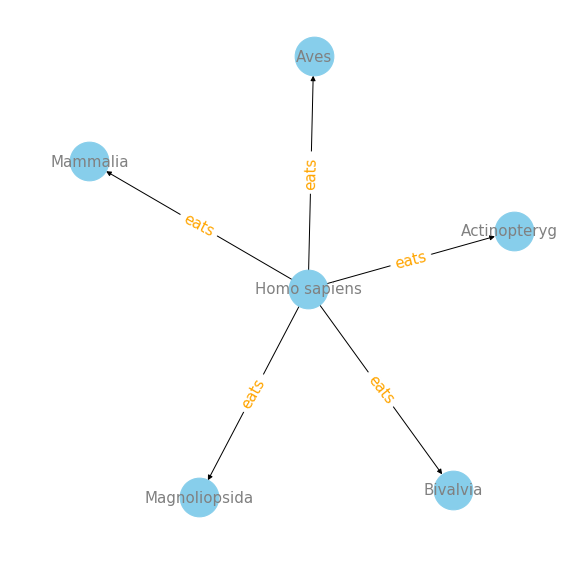

In [35]:
#interaction plot of top5 target classes that Homo sapiens eats:
plot_interaction('Homo sapiens', 'eats', 'targetTaxonClassName', 5)

We can see that Mammalia, Magnoliopsida, Actinopterygii, Aves and Bivalvia are top 5 target class that Homo sapiens eats. For me, it is surprising to see Magnoliopsida, which is a valid botanical name for a class of flowering plants.

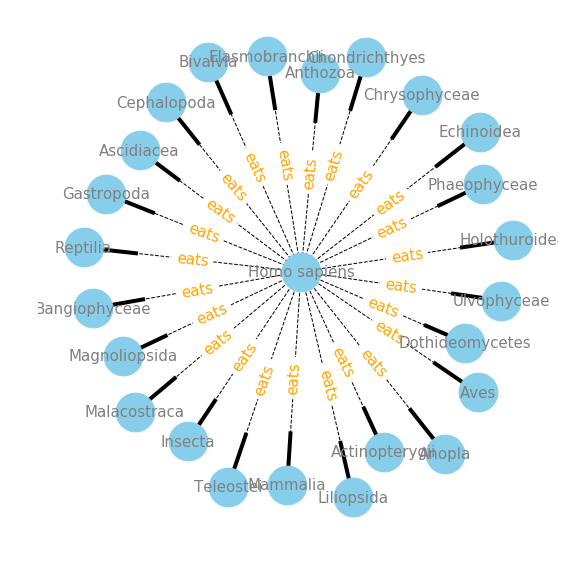

In [43]:
#without indicating n, interaction plot of all target classes that Homo sapiens eats:
plot_interaction('Homo sapiens', 'eats', 'targetTaxonClassName')

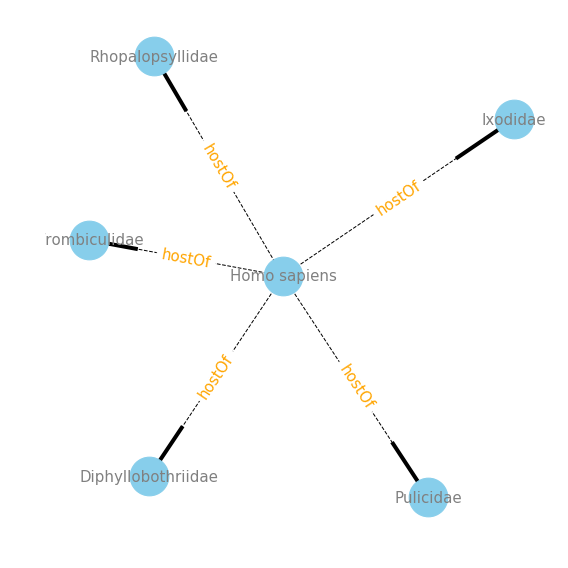

In [44]:
#interaction plot of top5 families that Homo sapiens are host of :
plot_interaction('Homo sapiens', 'hostOf', 'targetTaxonFamilyName', 5)

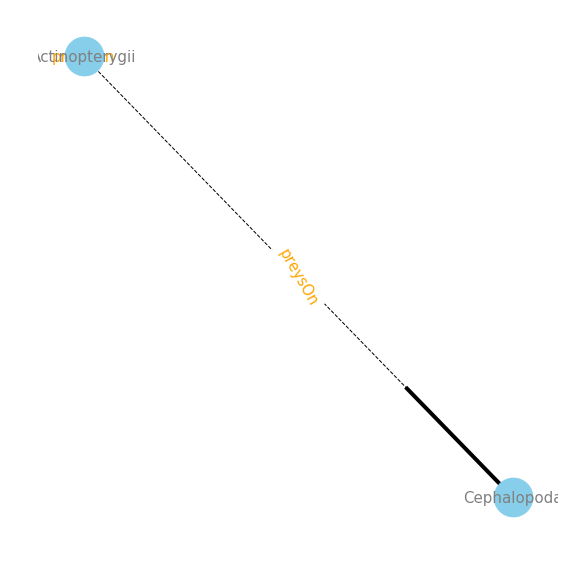

In [45]:
#interaction plot of top5 classes that Actinopterygii preys on :
plot_interaction('Actinopterygii', 'preysOn', 'targetTaxonClassName', 5)

Here it is interesting to see that Actinopterygii only preys on two classes, one of which is itself. Then it is possible that some species under class Actinopterygii preys on species under the same class. Fish eating other fish!

#### Plot more than one interaction type:

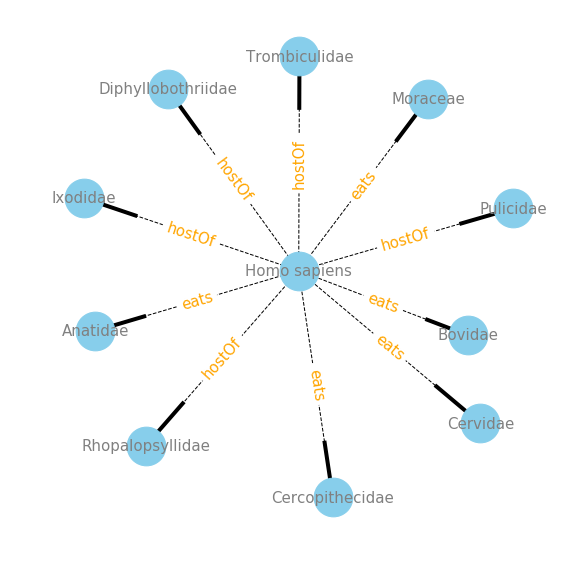

In [46]:
#interaction plot of top5 families that Homo sapiens eats and top5 families that Homo sapiens are host of :
plot_interaction('Homo sapiens', ['eats', 'hostOf'], 'targetTaxonFamilyName', 5)

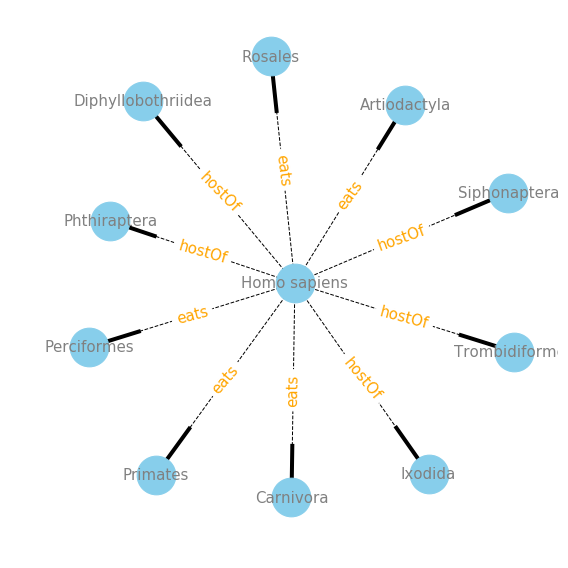

In [47]:
#interaction plot of top5 orders that Homo sapiens eats and top5 orders that Homo sapiens are host of :
plot_interaction('Homo sapiens', ['eats', 'hostOf'], 'targetTaxonOrderName', 5)

### Conclusion:

I really enjoyed my time working with the data in GloBi. GloBi speciallization of data of species interactions makes it different from other databases I explored. It makes connections between different species rather than focusing on one species at a time, which allows us to explore interesting characteristics and patterns in the networks built by interactions.  If I have time in the future, I would like to explore the map of interactions between species by connecting GloBi to other databases which contains information of locations. I expect interesting patterns to be found on the map. How does location affect interactions between species? This remains as a question worth of looking into.  

Through the overall data exploration, I learned how to make something into clickable urls. I also gained experience on drawing directed graph using "networkx" with python. In the past, I have little background knowledge in ecology, but after exploring Globi, I now know a lot more about interactions of human beings. I know what organims humans and bats eat and what animals humans are host of - all of which was new to me!

What is more, I also learnt about the API, cloud, queries and version cortrol behind the database. During my time exploring the GloBi database I got to discuss the database archetecture with one of the main contibutors of GloBi,  the discussion with Jorrit, we talked about where the limitations come from, how to keep track of different versions and how to effectively connect data sources(museums), database and users.  
Overall, it has been an enjoyable research, through which I have obtained a lot of new knowledge on database and ecology. It is also helpful to practice and enhance my programming skills.